# Testing Informer Performance on AIS Data

This notebook tests the mini Informer implementation on vessel trajectory data. We'll evaluate the model's ability to predict vessel movements using AIS data.

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Import your custom implementations
from informer_min import Informer
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load and preprocess data
MY_FILE = "dataset"
df = load_parquet(MY_FILE, k=100)
df = preprocess_data(df)

# Create dataset with sliding windows
window_size_minutes = 60  # Input sequence length
pred_size_minutes = 30    # Prediction sequence length
stride = 12              # Stride between windows

dataset = SlidingWindowDataset(
    df,
    max_diff_per_sequence_minutes=30,
    window_size_minutes=window_size_minutes,
    pred_size_minutes=pred_size_minutes,
    stride=stride,
)

print(f"Dataset size: {len(dataset)}")
print("\nExample window:")
x, y = dataset[0]
print(f"Input shape (x): {x.shape}")  # [seq_len, features]
print(f"Target shape (y): {y.shape}")  # [pred_len, features]

/zhome/63/7/219953/DeepLearning-1/dataloader.py:168: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/zhome/63/7/219953/DeepLearning-1/dataloader.py:168: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_index("Timestamp")


Dataset size: 7635

Example window:
Input shape (x): torch.Size([5, 4])
Target shape (y): torch.Size([5, 2])


In [3]:
# Configure model parameters
seq_len = x.shape[0]        # Length of input sequence
label_len = seq_len // 2    # Length of the decoder input sequence
pred_len = y.shape[0]       # Length of the prediction sequence
c_in = x.shape[1]          # Number of input features
c_out = y.shape[1]         # Number of output features (predicted coordinates)

# Model hyperparameters
model_config = {
    'c_in': c_in,
    'c_out': c_out,
    'seq_len': seq_len,
    'label_len': label_len,
    'pred_len': pred_len,
    'd_model': 256,        # Dimension of model
    'n_heads': 8,         # Number of attention heads
    'e_layers': 3,        # Number of encoder layers
    'd_layers': 2,        # Number of decoder layers
    'd_ff': 512,         # Dimension of FCN
    'dropout': 0.1,      # Dropout rate
    'top_u': None,       # Use default top-u for ProbSparse attention
    'distill': True,     # Use distilling in encoder
    'max_len': 4096      # Maximum sequence length for positional encoding
}

# Initialize model
model = Informer(**model_config).to(device)
print("\nModel configuration:")
for k, v in model_config.items():
    print(f"{k}: {v}")


Model configuration:
c_in: 4
c_out: 2
seq_len: 5
label_len: 2
pred_len: 5
d_model: 256
n_heads: 8
e_layers: 3
d_layers: 2
d_ff: 512
dropout: 0.1
top_u: None
distill: True
max_len: 4096


In [4]:
# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"\nDataset splits:")
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")


Dataset splits:
Train size: 5344
Validation size: 1145
Test size: 1146
Number of training batches: 167


In [5]:
# Training utilities
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Print shapes for debugging
        B = batch_x.shape[0]  # batch size
        # Create decoder input sequence
        dec_inp = batch_x[:, -model.label_len:, :]  # use last label_len points from input
        dec_inp = torch.cat([dec_inp, torch.zeros(B, model.pred_len, batch_x.shape[-1]).to(device)], dim=1)
        
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x, dec_inp)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            B = batch_x.shape[0]
            dec_inp = batch_x[:, -model.label_len:, :]
            dec_inp = torch.cat([dec_inp, torch.zeros(B, model.pred_len, batch_x.shape[-1]).to(device)], dim=1)
            
            outputs = model(batch_x, dec_inp)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

Starting training...
Epoch 1/50:
Train Loss: 366.508343
Val Loss: 3.492210
Learning Rate: 0.001000
--------------------------------------------------
Epoch 2/50:
Train Loss: 4.274871
Val Loss: 3.461761
Learning Rate: 0.001000
--------------------------------------------------
Epoch 3/50:
Train Loss: 2.939174
Val Loss: 2.961181
Learning Rate: 0.001000
--------------------------------------------------
Epoch 4/50:
Train Loss: 2.914895
Val Loss: 3.083515
Learning Rate: 0.001000
--------------------------------------------------
Epoch 5/50:
Train Loss: 2.899517
Val Loss: 2.993242
Learning Rate: 0.001000
--------------------------------------------------
Epoch 6/50:
Train Loss: 2.895246
Val Loss: 2.947324
Learning Rate: 0.001000
--------------------------------------------------
Epoch 7/50:
Train Loss: 2.880652
Val Loss: 2.956974
Learning Rate: 0.001000
--------------------------------------------------
Epoch 8/50:
Train Loss: 2.898949
Val Loss: 2.907099
Learning Rate: 0.001000
------------

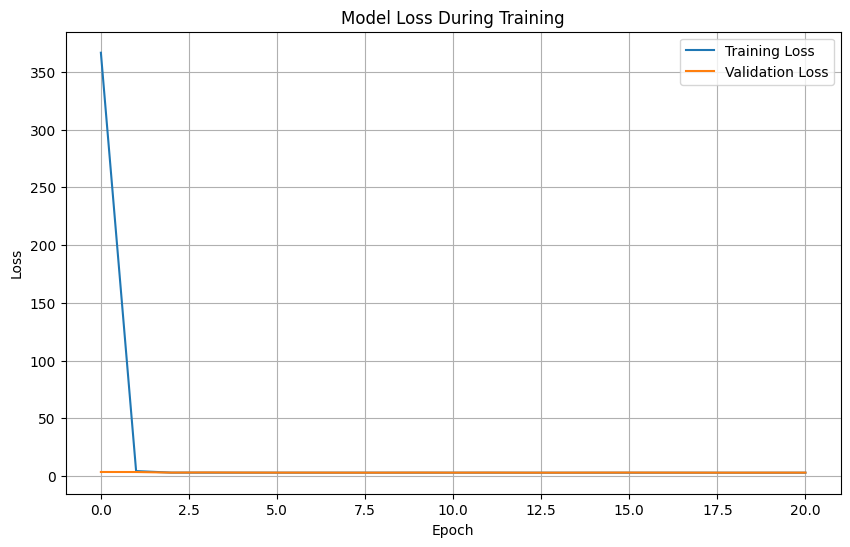

In [6]:
# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
early_stopping = EarlyStopping(patience=7)

num_epochs = 50
train_losses = []
val_losses = []
best_model_path = 'best_informer_model.pth'
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
    
    # Early stopping
    early_stopping(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.6f}')
    print(f'Val Loss: {val_loss:.6f}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    print('-' * 50)
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
early_stopping = EarlyStopping(patience=7)

num_epochs = 50
train_losses = []
val_losses = []
best_model_path = 'best_informer_model.pth'
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
    
    # Early stopping
    early_stopping(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.6f}')
    print(f'Val Loss: {val_loss:.6f}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    print('-' * 50)
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Starting training...
Epoch 1/50:
Train Loss: 366.508343
Val Loss: 3.492210
Learning Rate: 0.001000
--------------------------------------------------
Epoch 2/50:
Train Loss: 4.274871
Val Loss: 3.461761
Learning Rate: 0.001000
--------------------------------------------------
Epoch 3/50:
Train Loss: 2.939174
Val Loss: 2.961181
Learning Rate: 0.001000
--------------------------------------------------
Epoch 4/50:
Train Loss: 2.914895
Val Loss: 3.083515
Learning Rate: 0.001000
--------------------------------------------------
Epoch 5/50:
Train Loss: 2.899517
Val Loss: 2.993242
Learning Rate: 0.001000
--------------------------------------------------
Epoch 6/50:
Train Loss: 2.895246
Val Loss: 2.947324
Learning Rate: 0.001000
--------------------------------------------------
Epoch 7/50:
Train Loss: 2.880652
Val Loss: 2.956974
Learning Rate: 0.001000
--------------------------------------------------
Epoch 8/50:
Train Loss: 2.898949
Val Loss: 2.907099
Learning Rate: 0.001000
------------

In [7]:
# Evaluate model on test set
def calculate_metrics(true, pred):
    mse = ((true - pred) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(true - pred).mean()
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:

        # inside the batch loop
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        B = batch_x.size(0)
        D = batch_x.size(2)               # feature dim (should be c_in, e.g. 4)
        dec_ctx = batch_x[:, -model.label_len:, :]   # [B, label_len, D]
        zeros_tail = torch.zeros(B, model.pred_len, D, device=batch_x.device)  # [B, pred_len, D]
        dec_inp = torch.cat([dec_ctx, zeros_tail], dim=1)  # [B, label_len+pred_len, D]
        # Sanity checks
        assert dec_inp.shape[1] == (model.label_len + model.pred_len)
        assert dec_inp.shape[2] == batch_x.shape[2]

        outputs = model(batch_x, dec_inp)
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(batch_y.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Calculate metrics for each feature
metrics = {}
for i in range(c_out):
    feature_metrics = calculate_metrics(test_targets[:, :, i], test_predictions[:, :, i])
    metrics[f'Feature_{i}'] = feature_metrics

print("\nTest Set Metrics:")
for feature, feature_metrics in metrics.items():
    print(f"\n{feature}:")
    for metric_name, value in feature_metrics.items():
        print(f"{metric_name}: {value:.6f}")


Test Set Metrics:

Feature_0:
MSE: 1.292683
RMSE: 1.136962
MAE: 1.005716

Feature_1:
MSE: 4.070010
RMSE: 2.017426
MAE: 1.526001



Sample 1:


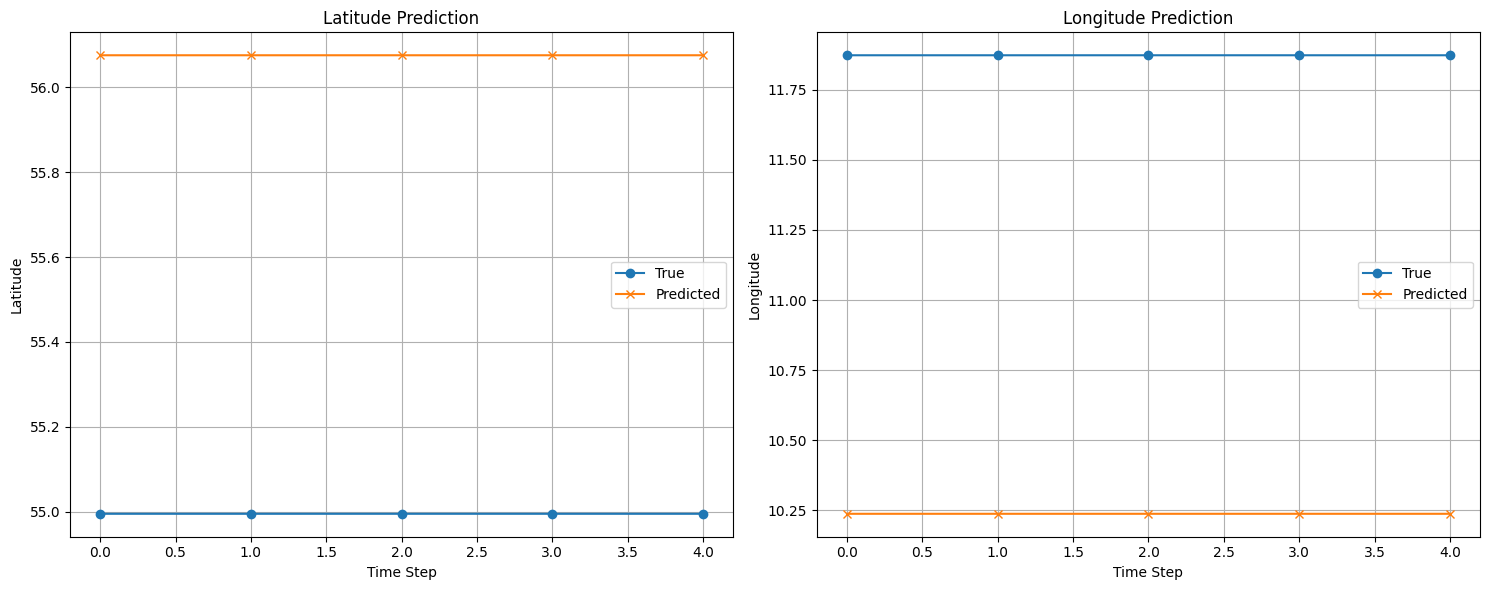


Sample 2:


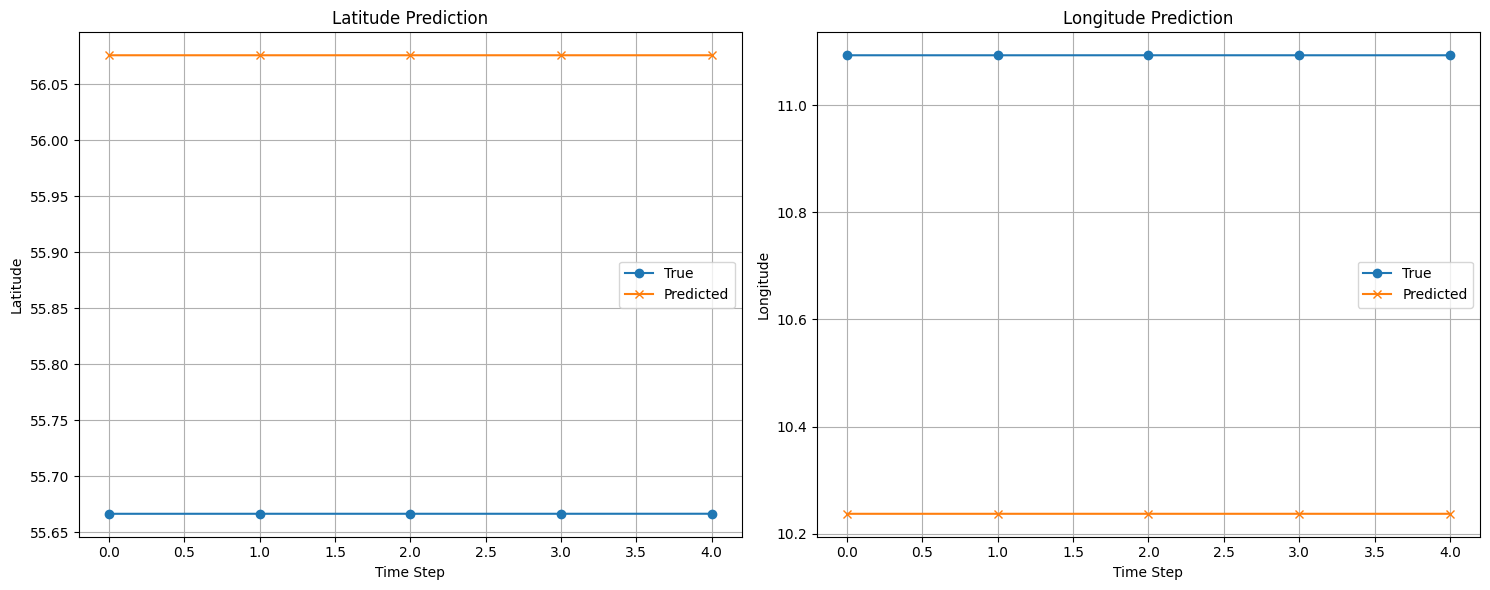


Sample 3:


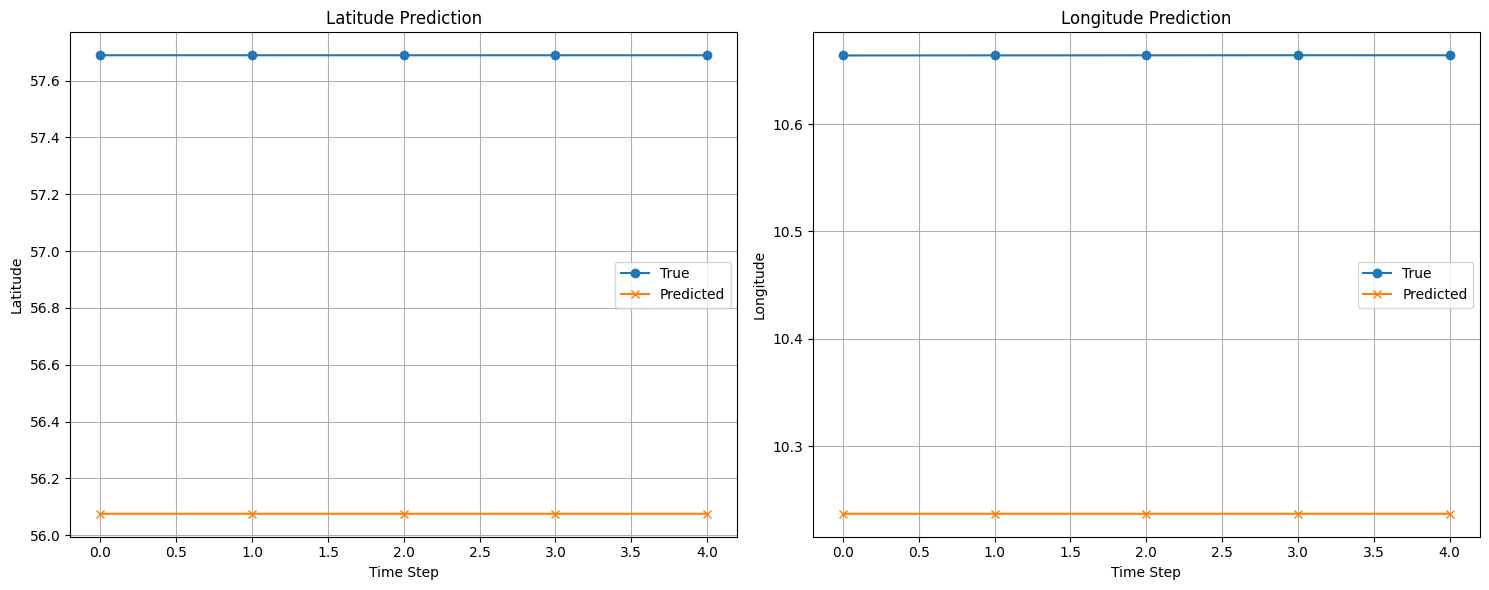


Trajectory 1:


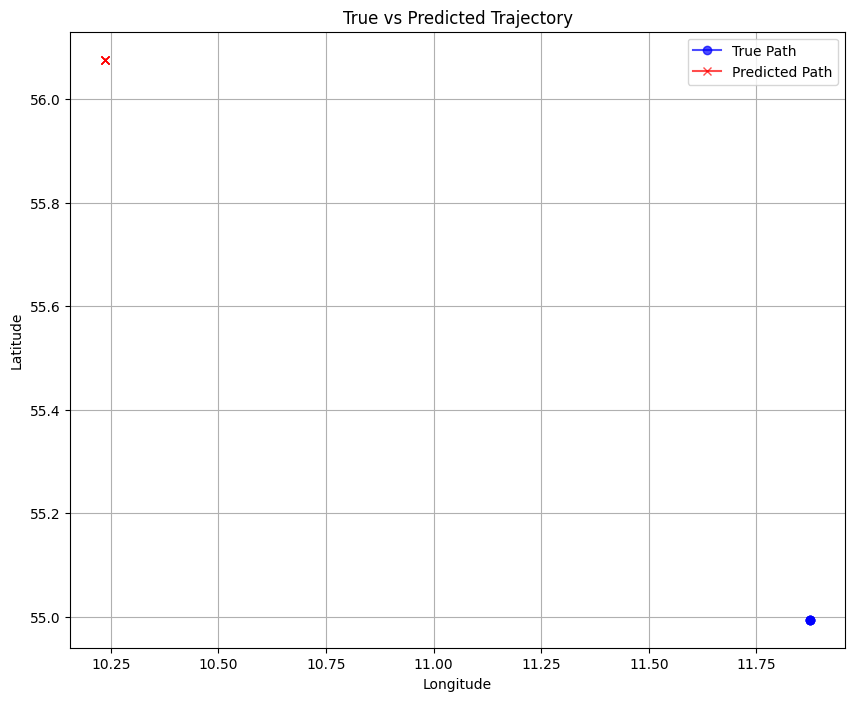


Trajectory 2:


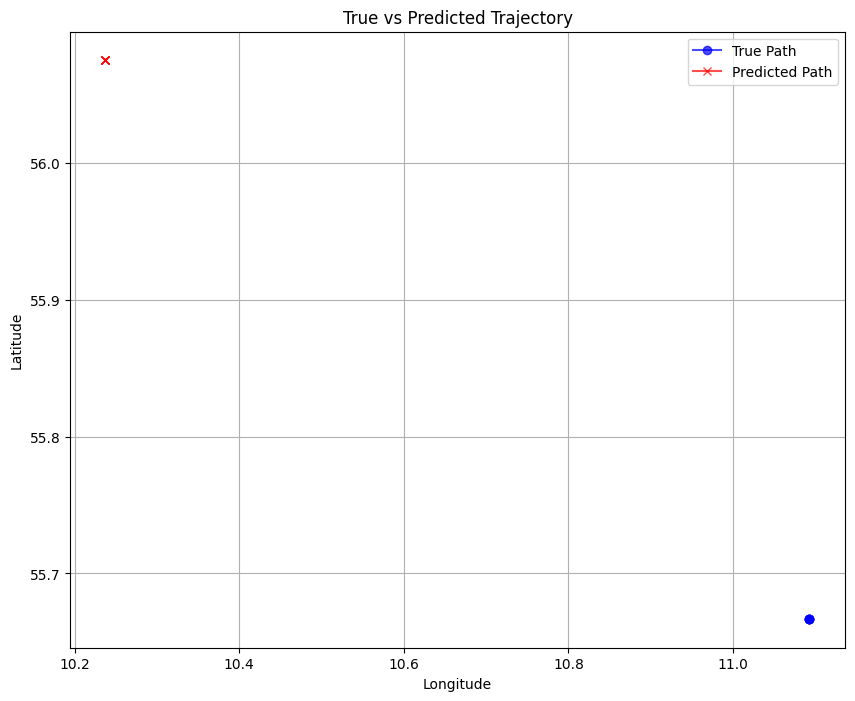


Trajectory 3:


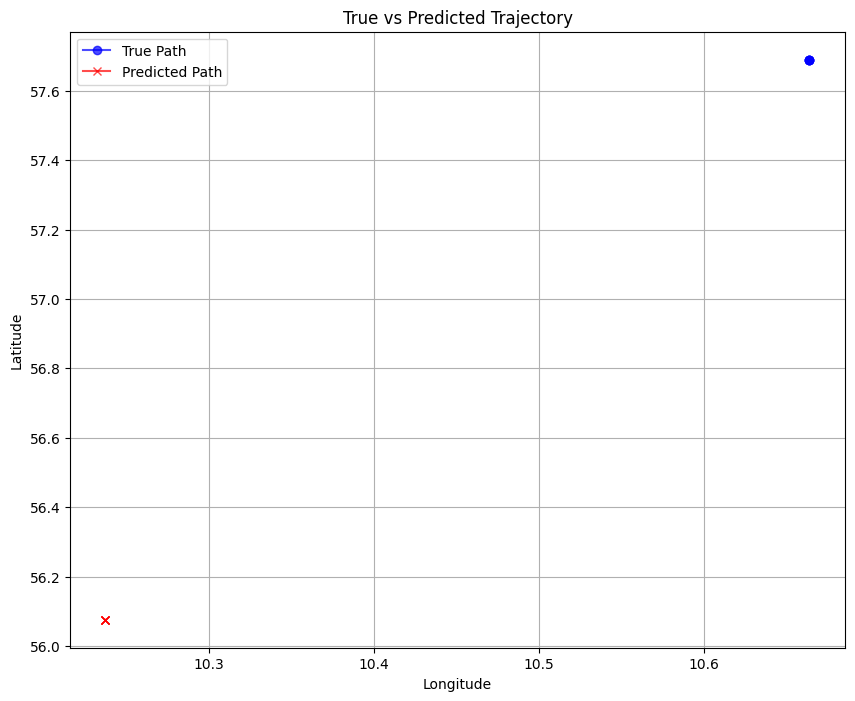

In [8]:
# Visualize predictions
def plot_predictions(true, pred, sample_idx=0):
    """Plot true vs predicted trajectories for a single sample"""
    plt.figure(figsize=(15, 6))
    
    # Plot latitude predictions
    plt.subplot(1, 2, 1)
    plt.plot(true[sample_idx, :, 0], label='True', marker='o')
    plt.plot(pred[sample_idx, :, 0], label='Predicted', marker='x')
    plt.title('Latitude Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    
    # Plot longitude predictions
    plt.subplot(1, 2, 2)
    plt.plot(true[sample_idx, :, 1], label='True', marker='o')
    plt.plot(pred[sample_idx, :, 1], label='Predicted', marker='x')
    plt.title('Longitude Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Longitude')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot predictions for a few samples
for i in range(3):
    print(f"\nSample {i+1}:")
    plot_predictions(test_targets, test_predictions, sample_idx=i)

# Plot trajectory on map
def plot_trajectory_on_map(true, pred, sample_idx=0):
    plt.figure(figsize=(10, 8))
    
    # Plot true trajectory
    plt.plot(true[sample_idx, :, 1], true[sample_idx, :, 0], 
             'b-o', label='True Path', alpha=0.7)
    
    # Plot predicted trajectory
    plt.plot(pred[sample_idx, :, 1], pred[sample_idx, :, 0], 
             'r-x', label='Predicted Path', alpha=0.7)
    
    # Add arrows to show direction
    for i in range(len(true[sample_idx])-1):
        plt.arrow(true[sample_idx, i, 1], true[sample_idx, i, 0],
                 true[sample_idx, i+1, 1] - true[sample_idx, i, 1],
                 true[sample_idx, i+1, 0] - true[sample_idx, i, 0],
                 head_width=0.0001, head_length=0.0001, fc='b', ec='b', alpha=0.3)
    
    plt.title('True vs Predicted Trajectory')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot trajectories on map for a few samples
for i in range(3):
    print(f"\nTrajectory {i+1}:")
    plot_trajectory_on_map(test_targets, test_predictions, sample_idx=i)

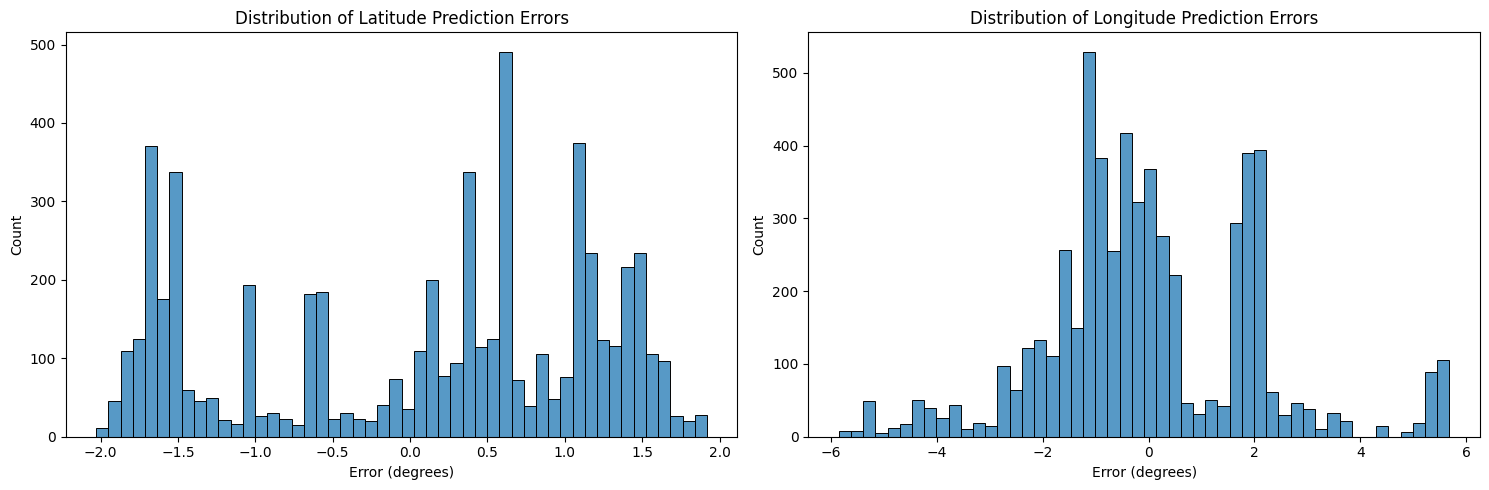


Error Statistics:

Latitude Errors:
Mean: 0.049303
Std: 1.135893
Min: -2.028641
Max: 1.918312

Longitude Errors:
Mean: -0.019946
Std: 2.017328
Min: -5.848965
Max: 5.680964


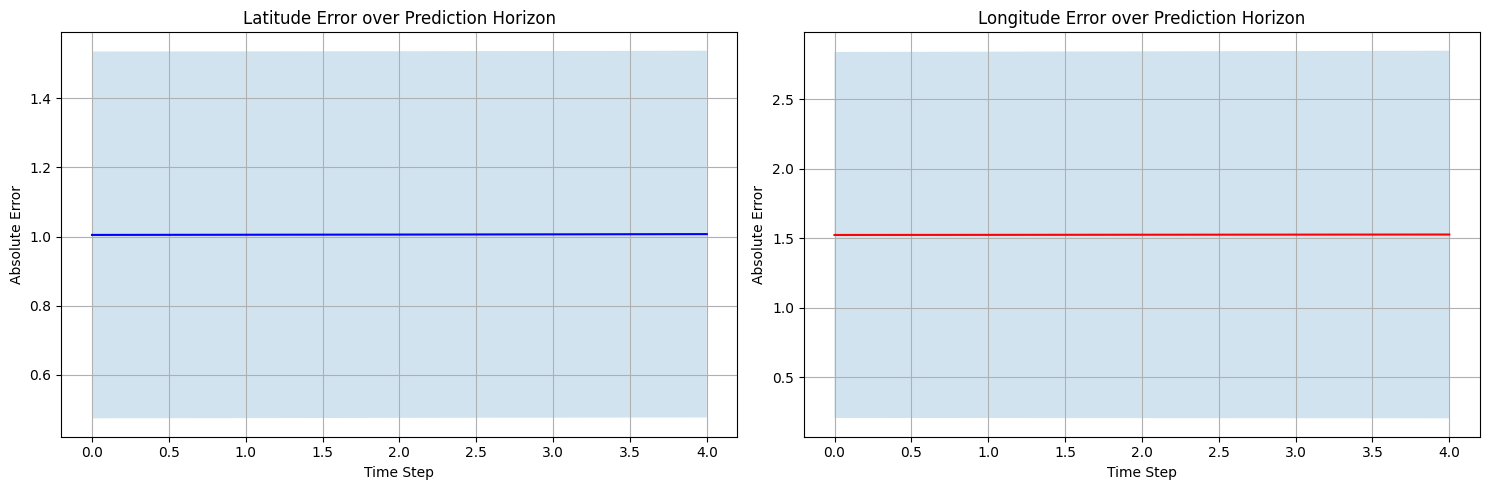

In [9]:
# Error Analysis
def plot_error_distribution():
    errors = test_predictions - test_targets
    
    plt.figure(figsize=(15, 5))
    
    # Latitude errors
    plt.subplot(1, 2, 1)
    sns.histplot(errors[:, :, 0].flatten(), bins=50)
    plt.title('Distribution of Latitude Prediction Errors')
    plt.xlabel('Error (degrees)')
    
    # Longitude errors
    plt.subplot(1, 2, 2)
    sns.histplot(errors[:, :, 1].flatten(), bins=50)
    plt.title('Distribution of Longitude Prediction Errors')
    plt.xlabel('Error (degrees)')
    
    plt.tight_layout()
    plt.show()
    
    # Print error statistics
    print("\nError Statistics:")
    for i, feature in enumerate(['Latitude', 'Longitude']):
        errors_feature = errors[:, :, i].flatten()
        print(f"\n{feature} Errors:")
        print(f"Mean: {errors_feature.mean():.6f}")
        print(f"Std: {errors_feature.std():.6f}")
        print(f"Min: {errors_feature.min():.6f}")
        print(f"Max: {errors_feature.max():.6f}")

plot_error_distribution()

# Calculate and plot error over prediction horizon
def plot_error_over_horizon():
    errors = np.abs(test_predictions - test_targets)
    mean_errors = errors.mean(axis=0)  # Average across samples
    std_errors = errors.std(axis=0)    # Standard deviation across samples
    
    time_steps = np.arange(pred_len)
    
    plt.figure(figsize=(15, 5))
    
    # Latitude errors
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, mean_errors[:, 0], 'b-', label='Mean Error')
    plt.fill_between(time_steps, 
                    mean_errors[:, 0] - std_errors[:, 0],
                    mean_errors[:, 0] + std_errors[:, 0],
                    alpha=0.2)
    plt.title('Latitude Error over Prediction Horizon')
    plt.xlabel('Time Step')
    plt.ylabel('Absolute Error')
    plt.grid(True)
    
    # Longitude errors
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, mean_errors[:, 1], 'r-', label='Mean Error')
    plt.fill_between(time_steps, 
                    mean_errors[:, 1] - std_errors[:, 1],
                    mean_errors[:, 1] + std_errors[:, 1],
                    alpha=0.2)
    plt.title('Longitude Error over Prediction Horizon')
    plt.xlabel('Time Step')
    plt.ylabel('Absolute Error')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_error_over_horizon()